# Fully Convolutional Networks for Semantic Segmentation

https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf

In this project, you are asked to implement the final architecture of *FCN8s*. 

Please read the paper carefully and understand concepts to answer questions in the grading interview.

##### Student Name: Tomas David Medina Romero

<img src="imgs/figure.png" alt="Figure" style="width: 500px;"/>

<img src="imgs/banner.png" alt="Figure" style="width: 1000px;"/>

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import datetime
import pytz
import matplotlib.pyplot as plt
import math
import os.path as osp
from torch.utils import *
import skimage
import sys
import os.path as osp
from utils import *
#from utils import get_upsampling_weight

In [12]:
torch.cuda.is_available()

True

In [13]:
# the VOC dataset will be downloaded to "data/dataset/VOC"
!bash '/content/drive/My Drive/Deep Learning/project3/download_dataset.sh' #download_dataset.sh

In [14]:
import numpy as np
import scipy.io
import PIL.Image
import collections

# Task1: VOC Segmentation DataLoader (10 points)
Please complete the following code for loading the data of VOC in a pytorch dataloader. You have to implement the tasks below once in SBDClassSeg and copy your implementation to VOCClassSegBase.
However there is a small difference in VOCClassSegBase. See the instructions below.

In [15]:
# hint: you can uncomment the functions (transform, __getitem__) first, then do the following:
        # segmentaion_dataloder = SBDClassSeg(dataset_path, split='train', transform=False)
        # print(segmentaion_dataloder.files)
# to understand what self.files is.
class SBDClassSeg(torch.utils.data.Dataset):
    url = 'http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/semantic_contours/benchmark.tgz'
    mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])
    class_names = np.array([
        'background',
        'aeroplane',
        'bicycle',
        'bird',
        'boat',
        'bottle',
        'bus',
        'car',
        'cat',
        'chair',
        'cow',
        'diningtable',
        'dog',
        'horse',
        'motorbike',
        'person',
        'potted plant',
        'sheep',
        'sofa',
        'train',
        'tv/monitor',
    ])
    
    def __init__(self, root, split='train', transform=False):
        # here we load the images and their labels into self.files[split]['img'] and self.files[split]['lbl']
        self.root = root
        self.split = split
        self._transform = transform

        dataset_dir = osp.join(self.root, 'VOC/benchmark_RELEASE/dataset')
        self.files = collections.defaultdict(list)
        for split in ['train', 'val']:
            imgsets_file = osp.join(dataset_dir, '%s.txt' % split)
            for did in open(imgsets_file):
                did = did.strip()
                img_file = osp.join(dataset_dir, 'img/%s.jpg' % did)
                lbl_file = osp.join(dataset_dir, 'cls/%s.mat' % did)
                self.files[split].append({
                    'img': img_file,
                    'lbl': lbl_file,
                })
                
    def __len__(self):
        return len(self.files[self.split])
    
    def transform(self, img, lbl):
        img = img[:, :, ::-1]  # RGB -> BGR  # load imgs in np (uint8)
        img = img.astype(np.float64)
        img -= self.mean_bgr # substract imag with the mean_bgr
        
        # TODO: Task 1.1 (5 points)
        # Transform images (numpy) to tensor 
        # input: img (H, W, C), np.float64; lbl (label): (1, ), np.int32
        # return img, lbl (torch.tensor)
        # hint1: what's the difference of numpy and tesor w.r.t the shape of images?
        # hint2: tranpose; from_numpy; the dtype of img tensor; the dtype of lable tensor;
        ################################################
        img = img.transpose(2,0,1)
        img = torch.from_numpy(img).float()
        lbl = torch.tensor(lbl).long()
        ################################################
        return img, lbl

    def untransform(self, img, lbl):
        img = img.numpy()
        img = img.transpose(1, 2, 0)
        img += self.mean_bgr
        img = img.astype(np.uint8)
        img = img[:, :, ::-1]
        lbl = lbl.numpy()
        return img, lbl
    
    def __getitem__(self, index):
        data_file = self.files[self.split][index]
        
        # TODO: Task 1.2 (5 points)
        # Load img and lbl (label) into numpy 
        # hint1: what does self.files do? 
        # hint2: how to load image (.jpg) as a numpy array? (PIL, np)
        # hint3: how to load label (.mat format) to numpy? (scipy)
        ################################################
        # load image from data_file to img
        img = np.array(PIL.Image.open(data_file['img'])).astype(dtype=np.uint8)
        # load label from data_file to lbl_mat
        lbl_mat = scipy.io.loadmat(data_file['lbl'])
        ################################################
        
        lbl = lbl_mat['GTcls'][0]['Segmentation'][0].astype(np.int32)
        lbl[lbl == 255] = -1 # -1 means wrong numbers, we have to mask the -1 out when calculate loss
        if self._transform:
            return self.transform(img, lbl)
        else:
            return img, lbl

In [16]:
# TODO: Copy your implementations above to their respective positions in the below class.
# PLEASE NOTE the difference in the lbl variable from the calss above
class VOCClassSegBase(torch.utils.data.Dataset):

    class_names = np.array([
        'background',
        'aeroplane',
        'bicycle',
        'bird',
        'boat',
        'bottle',
        'bus',
        'car',
        'cat',
        'chair',
        'cow',
        'diningtable',
        'dog',
        'horse',
        'motorbike',
        'person',
        'potted plant',
        'sheep',
        'sofa',
        'train',
        'tv/monitor',
    ])
    mean_bgr = np.array([104.00698793, 116.66876762, 122.67891434])

    def __init__(self, root, split='train', transform=False):
        self.root = root
        self.split = split
        self._transform = transform

        # VOC2011 and others are subset of VOC2012
        dataset_dir = osp.join(self.root, 'VOC/VOCdevkit/VOC2012')
        self.files = collections.defaultdict(list)
        for split in ['train', 'val']:
            imgsets_file = osp.join(
                dataset_dir, 'ImageSets/Segmentation/%s.txt' % split)
            for did in open(imgsets_file):
                did = did.strip()
                img_file = osp.join(dataset_dir, 'JPEGImages/%s.jpg' % did)
                lbl_file = osp.join(
                    dataset_dir, 'SegmentationClass/%s.png' % did)
                self.files[split].append({
                    'img': img_file,
                    'lbl': lbl_file,
                })

    def __len__(self):
        return len(self.files[self.split])

    def transform(self, img, lbl):
        img = img[:, :, ::-1]  # RGB -> BGR
        img = img.astype(np.float64)
        img -= self.mean_bgr

        # TODO: Task 1.1 (5 points)
        # Transform images (numpy) to tensor 
        # input: img (H, W, C), np.float64; lbl (label): (1, ), np.int32
        # return img, lbl (torch.tensor)
        # hint1: what's the difference of numpy and tesor w.r.t the shape of images?
        # hint2: tranpose; from_numpy; the dtype of img tensor; the dtype of lable tensor;
        ################################################
        img = img.transpose(2,0,1)
        img = torch.from_numpy(img).float()
        lbl = torch.tensor(lbl).long()
        ################################################
        return img, lbl

    def untransform(self, img, lbl):
        img = img.numpy()
        img = img.transpose(1, 2, 0)
        img += self.mean_bgr
        img = img.astype(np.uint8)
        img = img[:, :, ::-1]
        lbl = lbl.numpy()
        return img, lbl
    
    def __getitem__(self, index):
        data_file = self.files[self.split][index]
        
        # TODO: Task 1.2 (5 points)
        # Load img and lbl (label) into numpy 
        # hint1: what does self.files do? 
        # hint2: how to load image (.jpg) as a numpy array? (PIL, dtype=np.int8)
        # hint3: load the label here using PIL, since the validation data is different (dtype=np.int32). 
        ################################################
        # load image
        img = np.array(PIL.Image.open(data_file['img'])).astype(dtype=np.uint8)
        # load label
        lbl = np.array(PIL.Image.open(data_file['lbl'])).astype(dtype=np.int32)
        ################################################
        lbl[lbl == 255] = -1
        if self._transform:
            return self.transform(img, lbl)
        else:
            return img, lbl

# no need to modify the following class, but use it in loading validation data
class VOC2011ClassSeg(VOCClassSegBase):

    def __init__(self, root, split='train', transform=False):
        super(VOC2011ClassSeg, self).__init__(
            root, split=split, transform=transform)
        pkg_root = osp.dirname(osp.abspath(''))
        imgsets_file = './data/datasets/VOC/txt/seg11valid.txt'
        dataset_dir = osp.join(self.root, 'VOC/VOCdevkit/VOC2012')
        for did in open(imgsets_file):
            did = did.strip()
            img_file = osp.join(dataset_dir, 'JPEGImages/%s.jpg' % did)
            lbl_file = osp.join(dataset_dir, 'SegmentationClass/%s.png' % did)
            self.files['seg11valid'].append({'img': img_file, 'lbl': lbl_file})

## Visulize Dataset

In [17]:
dataset_path = './data/datasets'
seg_data = SBDClassSeg(dataset_path, split='train', transform=False)
train_loader = torch.utils.data.DataLoader(seg_data, batch_size=1, shuffle=True)

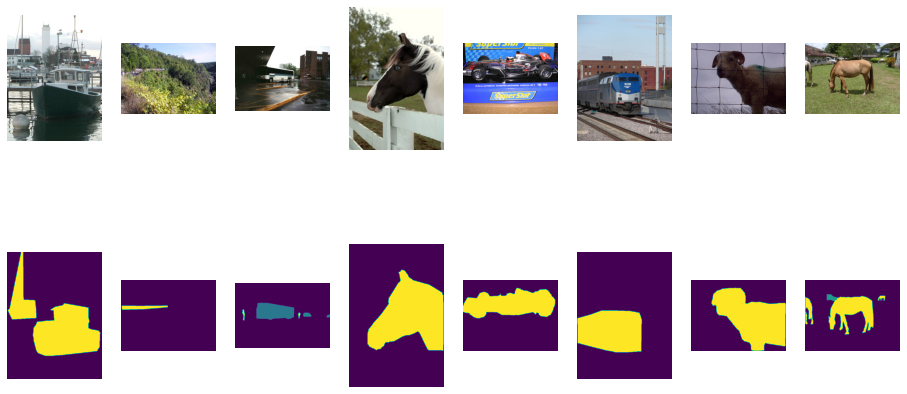

img.shape: torch.Size([1, 375, 500, 3]) 
 gt.shape:torch.Size([1, 375, 500])


In [18]:
iter_loder = iter(train_loader)
fig = plt.figure(figsize=(16, 8))
cols = 8
for i in range(cols):
    img, gt = iter_loder.next()
    fig.add_subplot(2, cols, i+1)
    plt.axis('off')
    plt.imshow(img.squeeze(0).numpy())
    fig.add_subplot(2, cols, i+1+cols)
    plt.axis('off')
    plt.imshow(gt.squeeze(0).numpy())
plt.show()

print('img.shape: {} \n gt.shape:{}'.format(img.shape, gt.shape))

# Task 2: Metric and Loss Function (30 points)
In task, you are asked to complete the implementation of evaluation metrics and loss calculation.

In [19]:
# Hint1: our goal is to calculate overall accuracy, mean class accuracy, IoU, mean IoU. You may need google them at first.
# Hint2: how to use confusion matrix to calculate above metrics for multicalss classfication/segmentation. 

In [20]:
def _get_confusion_matrix(label_true, label_pred, n_class):
    """
        Calculates the confusion matrix of a multiclass classifier
        confusion matrix: https://en.wikipedia.org/wiki/Confusion_matrix
    """
    # TODO: please undsertand what a confusion matrix is and why does the code below work for calculating confusion matrix.
    # You do not need to complete anything in this function, but this question may be asked in the interview.
    
    # why mask? : effective range of label should be [0, n_class)
    mask = (label_true >= 0) & (label_true < n_class)
    # key function to get the confusion matrix.  # explain why does this work?
    cm = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class) 
    return cm

def label_accuracy_score(label_trues, label_preds, n_class):
    """Returns accuracy score evaluation result.
      - overall accuracy: overall_acc
      - mean accuracy: mean_acc
      - mean IoU: mean_iu
      - frequence weighted IoU: fwiu
      
      # TODO: please read the FCN paper and understand the four common metrics for segmentation
    """
    # Now, we get the confusion matrix. 
    cm = np.zeros((n_class, n_class))
    for lt, lp in zip(label_trues, label_preds):
        cm += _get_confusion_matrix(lt.flatten(), lp.flatten(), n_class)
    
    # TODO: Task 2.1
    # overall accuracy (5 points)
    # hint: look up np.diag
    ################################################
    overall_acc = np.diag(cm).sum() / cm.sum()
    ################################################
    
    # TODO: Task 2.2  
    # mean class accuracy (5 points)
    # hint: look up np.diag
    ################################################
    with np.errstate(divide='ignore', invalid='ignore'):
        cls_acc = np.diag(cm) / cm.sum(axis=1)
    mean_acc = np.nanmean(cls_acc)
    ################################################
    
    # TODO: Task 2.3  
    # IoU and mean IoU (5 points)
    # hint: look up np.diag
    ################################################
    with np.errstate(divide='ignore', invalid='ignore'):
      union = (cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm))
      iu = np.diag(cm) / union
    mean_iu = np.nanmean(iu)
    ################################################
    
    # TODO: Task 2.4 
    # frequence weighted IoU (5 points)
    ################################################
    freq = (np.diag(cm)*cm.sum(axis=1)).sum() / union
    fwiu = freq/ cm.sum()
    ################################################
    return overall_acc, mean_acc, mean_iu, fwiu

In [21]:
def cross_entropy2d(input, target, weight=None, size_average=True):
    # input: (n, c, h, w), target: (n, h, w)
    n, c, h, w = input.size()    
    # TODO: Task 2.5 (5 points)
    # Use a softmax
    # log_p: (n*h*w, c)
    ################################################
    log_p = F.softmax(input,dim=1)
    ################################################
    log_p = log_p.transpose(1, 2).transpose(2, 3).contiguous()
    log_p = log_p[target.view(n, h, w, 1).repeat(1, 1, 1, c) >= 0]
    log_p = log_p.view(-1, c)
    
    # TODO: Task 2.6 (5 points)
    # Mask any negatives in target, do not consider anything smaller than 0
    # Then, call F.nll_loss to calculate the negative log likelihood loss and return the result.
    # target: (n*h*w,)
    ################################################
    mask = target >=0
    target = target[mask]
    loss = F.nll_loss(log_p,target,weight=weight,size_average=False)
    ################################################
    if size_average:
        loss /= mask.data.sum()
    return loss

# Task3: Network Architecture (40 points)

<img src="imgs/fig_arch.PNG" alt="Figure" style="width: 1000px;"/>

In [22]:
class FCN8s(nn.Module):
    def __init__(self, n_class=21):
        super(FCN8s, self).__init__()
        # TODO: please read the FCN paper and understand FCN8s (we will ask questions in the interview)
        # TODO: Implement the architecture (25 points)
        
        # TODO: conv1. conv-relu-conv-relu-pool1: 3 -> 64 (5 points)
        ################################################
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        ################################################

        # TODO: conv2. conv-relu-conv-relu-pool1: 64-> 128 (5 points)
        ################################################
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        ################################################

        # TODO: conv3. conv-relu-conv-relu-pool1: 128-> 256 (5 points)
        ################################################
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        ################################################

        # TODO: conv4. conv-relu-conv-relu-pool1: 256-> 512 (5 points)
        ################################################
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        ################################################

        # TODO: conv5. conv-relu-conv-relu-pool1: 512-> 512 (5 points)
        ################################################
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
        ################################################

        # TODO: fc6. The first fully connected layer. (4 points)
        # fc6. fc-relu-dropout 512->4096
        ################################################
        self.fc6 = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.dropout6 = nn.Dropout2d()
        ################################################

        # TODO: fc7  (4 points)
        ################################################
        self.fc7 = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.dropout7 = nn.Dropout2d()
        ################################################
        
        # 3 output scores 
        self.score_fr = nn.Conv2d(4096, n_class, 1)
        self.score_pool3 = nn.Conv2d(256, n_class, 1)
        self.score_pool4 = nn.Conv2d(512, n_class, 1)

        # TODO: 3 upsampling layers (2 points) 
        # hint: ConvTranspose2d
        ################################################
        self.upscore2 = nn.ConvTranspose2d(n_class, n_class, 4, stride=2, bias=False)
        self.upscore8 = nn.ConvTranspose2d(n_class, n_class, 16, stride=8, bias=False)
        self.upscore_pool4 = nn.ConvTranspose2d(n_class, n_class, 4, stride=2, bias=False)
        ################################################

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = get_upsampling_weight(m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)
                
    def forward(self, x):
        # TODO: complete the forward pass. (5 points)
        ################################################
        h = x
        h = self.pool1(self.relu1_2(self.conv1_2(self.relu1_1(self.conv1_1(h)))))
        h = self.pool2(self.relu2_2(self.conv2_2(self.relu2_1(self.conv2_1(h)))))
        h = self.pool3(self.relu3_3(self.conv3_3(self.relu3_2(self.conv3_2(self.relu3_1(self.conv3_1(h)))))))
        pool3 = h
        h = self.pool4(self.relu4_3(self.conv4_3(self.relu4_2(self.conv4_2(self.relu4_1(self.conv4_1(h)))))))
        pool4 = h
        h = self.pool5(self.relu5_3(self.conv5_3(self.relu5_2(self.conv5_2(self.relu5_1(self.conv5_1(h)))))))

        h = self.dropout6(self.relu6(self.fc6(h)))
        h = self.dropout7(self.relu7(self.fc7(h)))
        

        h = self.score_fr(h)
        h = self.upscore2(h)
        upscore2 = h
        
        h = self.score_pool4(pool4 * 0.01)  
        h = h[:, :, 5:5 + upscore2.size()[2], 5:5 + upscore2.size()[3]]
        score_pool4c = h  # 1/16

        h = upscore2 + score_pool4c # skip connection  # 1/16
        h = self.upscore_pool4(h)
        upscore_pool4 = h  # 1/8

        h = self.score_pool3(pool3 * 0.0001) 
        h = h[:, :,
              9:9 + upscore_pool4.size()[2],
              9:9 + upscore_pool4.size()[3]]
        score_pool3c = h  # 1/8

        h = upscore_pool4 + score_pool3c # skip connection  # 1/8

        h = self.upscore8(h)
        ################################################
        h = h[:, :, 31:31 + x.size()[2], 31:31 + x.size()[3]].contiguous()

        return h

    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data.copy_(l1.weight.data)
                l2.bias.data.copy_(l1.bias.data)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            print(l2.weight.size())
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            print(l2.weight.size())
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))
            print(l2.weight.size())

## Training (20 points)
Below, you are asked to complete some of the functions Trainer class and begin hyperparameter tuning and training.

In [23]:
import shutil

In [24]:
class Trainer(object):
    def __init__(self, cuda, model, optimizer,
                 train_loader, val_loader, out, max_iter,
                 size_average=False, interval_validate=None):
        self.cuda = cuda

        self.model = model
        self.optim = optimizer

        self.train_loader = train_loader
        self.val_loader = val_loader

        self.timestamp_start = \
            datetime.datetime.now(pytz.timezone('Asia/Riyadh'))
        self.size_average = size_average

        if interval_validate is None:
            self.interval_validate = len(self.train_loader)
        else:
            self.interval_validate = interval_validate

        self.out = out
        if not osp.exists(self.out):
            os.makedirs(self.out)

        self.log_headers = [
            'epoch',
            'iteration',
            'train/loss',
            'train/acc',
            'train/acc_cls',
            'train/mean_iu',
            'train/fwavacc',
            'valid/loss',
            'valid/acc',
            'valid/acc_cls',
            'valid/mean_iu',
            'valid/fwavacc',
            'elapsed_time',
        ]
        if not osp.exists(osp.join(self.out, 'log.csv')):
            with open(osp.join(self.out, 'log.csv'), 'w') as f:
                f.write(','.join(self.log_headers) + '\n')

        self.epoch = 0
        self.iteration = 0
        self.max_iter = max_iter
        self.best_mean_iu = 0

    def validate(self):
        training = self.model.training
        # TODO: set the model to evaluation mode
        ################################################
        self.model.eval()
        ################################################

        n_class = len(self.val_loader.dataset.class_names)

        val_loss = 0
        visualizations = []
        label_trues, label_preds = [], []
        print('- Validating, iteration ', end='')
        print(self.iteration, end='')
        print(' ...')
        for batch_idx, (data, target) in enumerate(self.val_loader):
            if self.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            with torch.no_grad():
                score = self.model(data)
            
            # TODO: Call loss here
            ################################################
            loss = cross_entropy2d(data,target)
            ################################################
            
            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while validating')
            val_loss += loss_data / len(data)

            imgs = data.data.cpu()
            lbl_pred = score.data.max(1)[1].cpu().numpy()[:, :, :]
            lbl_true = target.data.cpu()
            for img, lt, lp in zip(imgs, lbl_true, lbl_pred):
                img, lt = self.val_loader.dataset.untransform(img, lt)
                label_trues.append(lt)
                label_preds.append(lp)
                if len(visualizations) < 9:
                    viz = visualize_segmentation(
                        lbl_pred=lp, lbl_true=lt, img=img, n_class=n_class)
                    visualizations.append(viz)
        metrics = label_accuracy_score(
            label_trues, label_preds, n_class)

        out = osp.join(self.out, 'visualization_viz')
        if not osp.exists(out):
            os.makedirs(out)
        out_file = osp.join(out, 'iter%012d.jpg' % self.iteration)
        skimage.io.imsave(out_file, get_tile_image(visualizations))

        val_loss /= len(self.val_loader)

        with open(osp.join(self.out, 'log.csv'), 'a') as f:
            elapsed_time = (
                datetime.datetime.now(pytz.timezone('Asia/Tokyo')) -
                self.timestamp_start).total_seconds()
            log = [self.epoch, self.iteration] + [''] * 5 + \
                  [val_loss] + list(metrics) + [elapsed_time]
            log = map(str, log)
            f.write(','.join(log) + '\n')

        mean_iu = metrics[2]
        is_best = mean_iu > self.best_mean_iu
        if is_best:
            self.best_mean_iu = mean_iu
        torch.save({
            'epoch': self.epoch,
            'iteration': self.iteration,
            'arch': self.model.__class__.__name__,
            'optim_state_dict': self.optim.state_dict(),
            'model_state_dict': self.model.state_dict(),
            'best_mean_iu': self.best_mean_iu,
        }, osp.join(self.out, 'checkpoint.pth.tar'))
        if is_best:
            shutil.copy(osp.join(self.out, 'checkpoint.pth.tar'),
                        osp.join(self.out, 'model_best.pth.tar'))
        
        print('-- Done validating at iteration ', end='')
        print(self.iteration)
        print('---- val_loss = ', end='')
        print(val_loss)
        print('---- mean_iu = ', end='')
        print(mean_iu)
        print('- Resuming training...')
        if training:
            self.model.train()

    def train_epoch(self):
        # TODO: set the model to training mode
        ################################################
        self.model.train()
        ################################################

        n_class = len(self.train_loader.dataset.class_names)
        
        print('- Training, epoch ', end='')
        print(self.epoch, end='')
        print(' ...')
        for batch_idx, (data, target) in enumerate(self.train_loader):
            iteration = batch_idx + self.epoch * len(self.train_loader)
            if self.iteration != 0 and (iteration - 1) != self.iteration:
                continue  # for resuming
            self.iteration = iteration

            if self.iteration % self.interval_validate == 0:
                self.validate()

            assert self.model.training

            if self.cuda:
                data, target = data.cuda(), target.cuda()
            data, target = Variable(data), Variable(target)
            self.optim.zero_grad()
            score = self.model(data)
            
            # TODO: Call loss here
            ################################################
            loss = cross_entropy2d(data,target)
            ################################################
            
            loss /= len(data)
            loss_data = loss.data.item()
            if np.isnan(loss_data):
                raise ValueError('loss is nan while training')
                
            # TODO: Backprobagate, and initiate optimizer step
            ################################################
            loss.backward()
            #self.optim.zero_grad()
            self.optim.step()
            ################################################

            metrics = []
            lbl_pred = score.data.max(1)[1].cpu().numpy()[:, :, :]
            lbl_true = target.data.cpu().numpy()
            acc, acc_cls, mean_iu, fwavacc = \
                label_accuracy_score(
                    lbl_true, lbl_pred, n_class=n_class)
            metrics.append((acc, acc_cls, mean_iu, fwavacc))
            metrics = np.mean(metrics, axis=0)

            with open(osp.join(self.out, 'log.csv'), 'a') as f:
                elapsed_time = (
                    datetime.datetime.now(pytz.timezone('Asia/Tokyo')) -
                    self.timestamp_start).total_seconds()
                log = [self.epoch, self.iteration] + [loss_data] + \
                    metrics.tolist() + [''] * 5 + [elapsed_time]
                log = map(str, log)
                f.write(','.join(log) + '\n')

            if self.iteration >= self.max_iter:
                break

    def train(self):
        max_epoch = int(math.ceil(1. * self.max_iter / len(self.train_loader)))
        print('Started training!\n')
        print('Total epochs: ', end='')
        print(max_epoch)
        print('\n\n')
        for epoch in range(max_epoch): 
            self.epoch = epoch
            self.train_epoch()
            if self.iteration >= self.max_iter:
                break

## Training Setup

### hyperparameters Setup

In [25]:
# TODO: hyperparameters, choose suitable numbers
################################################
lr = 1e-4
weight_decay = 5e-4
momentum = 0.9
################################################
max_iteration = 100000
random_seed = 1337
cuda = torch.cuda.is_available()

In [26]:
# derterministic model
import random
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [28]:
# 1. Dataset
root = osp.expanduser('/content/data/datasets')
kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(SBDClassSeg(root, split='train', transform=True), batch_size=1, shuffle=True, **kwargs)
val_loader = torch.utils.data.DataLoader(VOC2011ClassSeg(root, split='seg11valid', transform=True), batch_size=1, shuffle=False, **kwargs)

In [29]:
# 2. Model
# TODO: Define your model, number of output classes is 21
################################################
model = FCN8s(n_class=21)
################################################
start_epoch = 0
start_iteration = 0

# TODO: load pretrained VGG16 weights
# hint: use the function copy_params_from_vgg16
################################################
vgg16 = model.copy_params_from_vgg16(VGG16(pretrained=True))
################################################

if cuda:
    model = model.cuda()

Downloading...
From: http://drive.google.com/uc?id=0B9P1L--7Wd2vLTJZMXpIRkVVRFk
To: /content/data/models/pytorch/vgg16_from_caffe.pth
553MB [00:08, 64.0MB/s]


torch.Size([4096, 512, 7, 7])
torch.Size([4096, 512, 7, 7])
torch.Size([4096, 512, 7, 7])
torch.Size([4096, 4096, 1, 1])
torch.Size([4096, 4096, 1, 1])
torch.Size([4096, 4096, 1, 1])


In [30]:
# 3. Optimizer
"""For optimization"""
# No need to edit, this is to set the bias and weight of the layers while skipping some of them
def get_parameters(model, bias=False):
    import torch.nn as nn
    modules_skipped = (
        nn.ReLU,
        nn.MaxPool2d,
        nn.Dropout2d,
        nn.Sequential,
        FCN8s,
    )
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            if bias:
                yield m.bias
            else:
                yield m.weight
        elif isinstance(m, nn.ConvTranspose2d):
            # weight is frozen because it is just a bilinear upsampling
            if bias:
                assert m.bias is None
        elif isinstance(m, modules_skipped):
            continue
        else:
            raise ValueError('Unexpected module: %s' % str(m))
            
optim = torch.optim.SGD([{'params': get_parameters(model, bias=False)}, {'params': get_parameters(model, bias=True), 'lr': lr * 2, 'weight_decay': 0},], lr=lr, momentum=momentum, weight_decay=weight_decay)
# no lr sheduler 

In [32]:
# 4. Train
# for log file
now = datetime.datetime.now()
out = osp.join(os.getcwd(), 'logs', now.strftime('%Y%m%d_%H%M%S.%f'))
trainer = Trainer(
    cuda=cuda,
    model=model,
    optimizer=optim,
    train_loader=train_loader,
    val_loader=val_loader,
    out=out,
    max_iter=max_iteration,
    interval_validate=4000,
)
trainer.epoch = start_epoch
trainer.iteration = start_iteration
trainer.train()

Started training!

Total epochs: 12



- Training, epoch 0 ...
- Validating, iteration 0 ...


RuntimeError: ignored

### Requirements and Reference Solution

Segmentation results and logs will be saved in ./logs/

You are expected to achieve AT LEAST *61.5 mean_IU*.

You are required to achieve results that look like the ones below or better:

<img src="imgs/reference_solution.jpg" alt="Figure" style="width: 1200px;"/>